In [1]:
import torch

from torch.utils.data import DataLoader

from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import AutoModelForCausalLM

from accelerate import Accelerator

from matplotlib import pyplot as plt

In [2]:
model_name="tiiuae/falcon-rw-1b"
dataset_name="yelp_review_full"
accelerator = Accelerator()

In [3]:
# Load the dataset.  Just load the train split.  Different datasets have different splits, but
# having a train split is common.
dataset = load_dataset(dataset_name, split="train")

In [4]:
# We only want to use a small subset of the dataset for this example.
# Note that dataset[:1000] would seem to work, but it doesn't.  In particular,
# dataset[:1000] is not a dataset object, but a dictionary.  So, we use the
# select method to get a dataset object.
dataset = dataset.shuffle(42).select(range(1000))

In [5]:
# This converts the dataset to a format that the model can understand.
# In particlar, it takes the words and converts them to numbers/tokens.
# Note, the pdding side is left since that is that the CausalLM model expects.
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
# NOTE: the tokenizer.pad_token is a special token that is used to pad sequences to the same length.
tokenizer.pad_token = tokenizer.eos_token

# NOT TESTED: I think this gets a batch of samples as defined by the map function.
# So, the longest refers to the longest sequence in the batch.
def tokenize_function(examples):
    return tokenizer(examples["text"], padding='longest', truncation=True, max_length=17)

# NOTE: the map function does some fancy caching.  I.e., the first time you run it, it will
# take a while.  But, the second time you run it, it will be much faster.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
# We don't need the labels anymore, so we remove them.
tokenized_datasets = tokenized_datasets.remove_columns(["label", "text"])
# From https://huggingface.co/docs/datasets/v2.15.0/en/package_reference/main_classes#datasets.Dataset.set_format
#     Set __getitem__ return format using this transform. The transform is applied on-the-fly on batches when __getitem__ is called. 
#     type (str, optional) — Either output type selected in [None, 'numpy', 'torch', 'tensorflow', 'pandas', 'arrow', 'jax']. None means __getitem__ returns python objects (default).
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets, shuffle=True, batch_size=8)

In [6]:
# A little sanity check.
print('example text')
print(dataset[0])
print('example tokenized text')
print(tokenized_datasets[0])
print('example decoded tokenized text')
print(tokenizer.decode(tokenized_datasets[0]['input_ids'][:10]))

example text
{'label': 4, 'text': "I stalk this truck.  I've been to industrial parks where I pretend to be a tech worker standing in line, strip mall parking lots, and of course the farmer's market.  The bowls are so so absolutely divine.  The owner is super friendly and he makes each bowl by hand with an incredible amount of pride.  You gotta eat here guys!!!"}
example tokenized text
{'input_ids': tensor([   40, 31297,   428,  7779,    13,   220,   314,  1053,   587,   284,
         7593, 14860,   810,   314, 16614,   284,   307]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}
example decoded tokenized text
I stalk this truck.  I've been to


In [7]:
class Spy(torch.nn.Module):
        def __init__(self, model, debug=False):
            super().__init__()
            self.model = model
            self.debug = debug
            self.inputs = []
            self.outputs = []
            self.last_size = 0

        def forward(self, *args, **kwargs):
            self.inputs.append(args)
            output = self.model(*args, **kwargs)
            self.outputs.append(output)
            if self.debug:
                print(f'args {args}')
                print(f'kwargs {kwargs}')
                print(f'output {output}')
            return output

        def print_last_input(self):
            print(f'{self.last_size} {len(self.inputs)}')
            for i in range(self.last_size, len(self.inputs)):
                print(f'{i} {self.inputs[i][0].shape}')
            self.last_size = len(self.inputs)


In [8]:
model = AutoModelForCausalLM.from_pretrained(model_name)
print(model)

FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(50304, 2048)
    (h): ModuleList(
      (0-23): 24 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (query_key_value): FalconLinear(in_features=2048, out_features=6144, bias=True)
          (dense): FalconLinear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): FalconLinear(in_features=2048, out_features=8192, bias=True)
          (act): GELU(approximate='none')
          (dense_4h_to_h): FalconLinear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=2048, out_feature

In [9]:
if model_name == "tiiuae/falcon-rw-1b":
    my_spy = Spy(model.transformer.h[3].self_attention)
    model.transformer.h[3].self_attention = my_spy
elif model_name == "bert-base-cased":
    my_spy = Spy(model.bert.encoder.layer[3])
    model.bert.encoder.layer[3] = my_spy
elif model_name == "mistralai/Mistral-7B-v0.1":
    my_spy = Spy(model.model.layers[5])
    model.model.layers[5] = my_spy
else:
    raise ValueError(f"Unknown model {model_name}")

In [10]:
prompt = "This is a review of a restaurant.  The food was"
input = tokenizer(prompt, return_tensors="pt").input_ids

In [11]:
model = accelerator.prepare(model)
# Note, the accelerator is cool, but only handles dataloaders.  So, for this example, we need to do it ourselves.
input = input.to(accelerator.device)

In [12]:
# This is a simplier way to do it, but does not give high quality results.
output = model.generate(input, max_new_tokens=100, use_cache=False, do_sample=False, top_k=50, top_p=0.95, pad_token_id=tokenizer.eos_token_id)
print(input.shape)
print(output.shape)
my_spy.print_last_input()

torch.Size([1, 12])
torch.Size([1, 25])
0 13
0 torch.Size([1, 12, 2048])
1 torch.Size([1, 13, 2048])
2 torch.Size([1, 14, 2048])
3 torch.Size([1, 15, 2048])
4 torch.Size([1, 16, 2048])
5 torch.Size([1, 17, 2048])
6 torch.Size([1, 18, 2048])
7 torch.Size([1, 19, 2048])
8 torch.Size([1, 20, 2048])
9 torch.Size([1, 21, 2048])
10 torch.Size([1, 22, 2048])
11 torch.Size([1, 23, 2048])
12 torch.Size([1, 24, 2048])


In [13]:
generated_text = tokenizer.decode(output[0])

In [14]:
print(f'prompt {prompt}')
print(f'generated_text {generated_text}')

prompt This is a review of a restaurant.  The food was
generated_text This is a review of a restaurant.  The food was good, but the service was terrible. The waitress was rude and


In [15]:
# This does some sampling that really seems to help, but I dont' understand it.
# https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/text_generation#transformers.GenerationMixin.sample
# Parameters that control the generation strategy used
# do_sample (bool, optional, defaults to False) — Whether or not to use sampling ; use greedy decoding otherwise.
# num_beams (int, optional, defaults to 1) — Number of beams for beam search. 1 means no beam search.
# num_beam_groups (int, optional, defaults to 1) — Number of groups to divide num_beams into in order to ensure diversity among different groups of beams. this paper for more details.
# penalty_alpha (float, optional) — The values balance the model confidence and the degeneration penalty in contrastive search decoding.
# use_cache (bool, optional, defaults to True) — Whether or not the model should use the past last key/values attentions (if applicable to the model) to speed up decoding.
# Parameters for manipulation of the model output logits

# temperature (float, optional, defaults to 1.0) — The value used to modulate the next token probabilities.
# top_k (int, optional, defaults to 50) — The number of highest probability vocabulary tokens to keep for top-k-filtering.
# top_p (float, optional, defaults to 1.0) — If set to float < 1, only the smallest set of most probable tokens with probabilities that add up to top_p or higher are kept for generation.
# output = model.generate(input, max_new_tokens=100, do_sample=False, top_k=50, top_p=0.95, pad_token_id=tokenizer.eos_token_id)

# Also, there is caching.  look at https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.max_new_tokens
# use_cache — (bool, optional, defaults to True): Whether or not the model should use the past last key/values attentions (if applicable to the model) to speed up decoding.
# The results are clearer if you set use_cache=False.  But, it is slower.
output = model.generate(input, max_new_tokens=100, use_cache=False, do_sample=False, top_k=50, top_p=0.95, pad_token_id=tokenizer.eos_token_id)
print(input.shape)
print(output.shape)
my_spy.print_last_input()

torch.Size([1, 12])
torch.Size([1, 112])
13 113
13 torch.Size([1, 12, 2048])
14 torch.Size([1, 13, 2048])
15 torch.Size([1, 14, 2048])
16 torch.Size([1, 15, 2048])
17 torch.Size([1, 16, 2048])
18 torch.Size([1, 17, 2048])
19 torch.Size([1, 18, 2048])
20 torch.Size([1, 19, 2048])
21 torch.Size([1, 20, 2048])
22 torch.Size([1, 21, 2048])
23 torch.Size([1, 22, 2048])
24 torch.Size([1, 23, 2048])
25 torch.Size([1, 24, 2048])
26 torch.Size([1, 25, 2048])
27 torch.Size([1, 26, 2048])
28 torch.Size([1, 27, 2048])
29 torch.Size([1, 28, 2048])
30 torch.Size([1, 29, 2048])
31 torch.Size([1, 30, 2048])
32 torch.Size([1, 31, 2048])
33 torch.Size([1, 32, 2048])
34 torch.Size([1, 33, 2048])
35 torch.Size([1, 34, 2048])
36 torch.Size([1, 35, 2048])
37 torch.Size([1, 36, 2048])
38 torch.Size([1, 37, 2048])
39 torch.Size([1, 38, 2048])
40 torch.Size([1, 39, 2048])
41 torch.Size([1, 40, 2048])
42 torch.Size([1, 41, 2048])
43 torch.Size([1, 42, 2048])
44 torch.Size([1, 43, 2048])
45 torch.Size([1, 44, 20

In [16]:
generated_text = tokenizer.decode(output[0])

In [17]:
print(f'prompt {prompt}')
print(f'generated_text {generated_text}')

prompt This is a review of a restaurant.  The food was
generated_text This is a review of a restaurant.  The food was good, but the service was terrible. The waitress was rude and unhelpful. The food was good, but the service was terrible. The food was good, but the service was terrible. The food was good, but the service was terrible. The food was good, but the service was terrible. The food was good, but the service was terrible. The food was good, but the service was terrible. The food was good, but the service was terrible. The food was good, but


In [18]:
input = tokenized_datasets['input_ids'][:10]
# Note, the accelerator is cool, but only handles dataloaders.  So, for this example, we need to do it ourselves.
input = input.to(accelerator.device)

output = model.generate(input, max_new_tokens=100, use_cache=False, do_sample=False, top_k=50, top_p=0.95, pad_token_id=tokenizer.eos_token_id)
print(input.shape)
print(output.shape)
my_spy.print_last_input()

for i in range(len(input)):
    print('-----------------------------------------------')
    print(f'input {tokenizer.decode(input[i])}')
    print('...............................................')
    print(f'output {tokenizer.decode(output[i])}')

torch.Size([10, 17])
torch.Size([10, 117])
113 213
113 torch.Size([10, 17, 2048])
114 torch.Size([10, 1, 2048])
115 torch.Size([10, 1, 2048])
116 torch.Size([10, 1, 2048])
117 torch.Size([10, 1, 2048])
118 torch.Size([10, 1, 2048])
119 torch.Size([10, 1, 2048])
120 torch.Size([10, 1, 2048])
121 torch.Size([10, 1, 2048])
122 torch.Size([10, 1, 2048])
123 torch.Size([10, 1, 2048])
124 torch.Size([10, 1, 2048])
125 torch.Size([10, 1, 2048])
126 torch.Size([10, 1, 2048])
127 torch.Size([10, 1, 2048])
128 torch.Size([10, 1, 2048])
129 torch.Size([10, 1, 2048])
130 torch.Size([10, 1, 2048])
131 torch.Size([10, 1, 2048])
132 torch.Size([10, 1, 2048])
133 torch.Size([10, 1, 2048])
134 torch.Size([10, 1, 2048])
135 torch.Size([10, 1, 2048])
136 torch.Size([10, 1, 2048])
137 torch.Size([10, 1, 2048])
138 torch.Size([10, 1, 2048])
139 torch.Size([10, 1, 2048])
140 torch.Size([10, 1, 2048])
141 torch.Size([10, 1, 2048])
142 torch.Size([10, 1, 2048])
143 torch.Size([10, 1, 2048])
144 torch.Size([10

In [19]:
# Ok, now we do the same thing, but with a dataloader.
model, train_dataloader = accelerator.prepare(model, train_dataloader)

batch = next(iter(train_dataloader))
input = batch['input_ids']

output = model.generate(input, max_new_tokens=100, use_cache=False, do_sample=False, top_k=50, top_p=0.95, pad_token_id=tokenizer.eos_token_id)
print(input.shape)
print(output.shape)
my_spy.print_last_input()

for i in range(len(input)):
    print('-----------------------------------------------')
    print(f'input {tokenizer.decode(input[i])}')
    print('...............................................')
    print(f'output {tokenizer.decode(output[i])}')

torch.Size([8, 17])
torch.Size([8, 117])
213 313
213 torch.Size([8, 17, 2048])
214 torch.Size([8, 1, 2048])
215 torch.Size([8, 1, 2048])
216 torch.Size([8, 1, 2048])
217 torch.Size([8, 1, 2048])
218 torch.Size([8, 1, 2048])
219 torch.Size([8, 1, 2048])
220 torch.Size([8, 1, 2048])
221 torch.Size([8, 1, 2048])
222 torch.Size([8, 1, 2048])
223 torch.Size([8, 1, 2048])
224 torch.Size([8, 1, 2048])
225 torch.Size([8, 1, 2048])
226 torch.Size([8, 1, 2048])
227 torch.Size([8, 1, 2048])
228 torch.Size([8, 1, 2048])
229 torch.Size([8, 1, 2048])
230 torch.Size([8, 1, 2048])
231 torch.Size([8, 1, 2048])
232 torch.Size([8, 1, 2048])
233 torch.Size([8, 1, 2048])
234 torch.Size([8, 1, 2048])
235 torch.Size([8, 1, 2048])
236 torch.Size([8, 1, 2048])
237 torch.Size([8, 1, 2048])
238 torch.Size([8, 1, 2048])
239 torch.Size([8, 1, 2048])
240 torch.Size([8, 1, 2048])
241 torch.Size([8, 1, 2048])
242 torch.Size([8, 1, 2048])
243 torch.Size([8, 1, 2048])
244 torch.Size([8, 1, 2048])
245 torch.Size([8, 1, 

In [20]:
for i in range(len(my_spy.inputs)):
    tmp_len = len(my_spy.inputs[i])
    if tmp_len != 1:
        print(f'{i} {tmp_len}')
# Every tuple if of length 1.

In [21]:
for i in range(len(my_spy.inputs)):
    tmp_shape = my_spy.inputs[i][0].shape
    print(f'{i} {tmp_shape}')


0 torch.Size([1, 12, 2048])
1 torch.Size([1, 13, 2048])
2 torch.Size([1, 14, 2048])
3 torch.Size([1, 15, 2048])
4 torch.Size([1, 16, 2048])
5 torch.Size([1, 17, 2048])
6 torch.Size([1, 18, 2048])
7 torch.Size([1, 19, 2048])
8 torch.Size([1, 20, 2048])
9 torch.Size([1, 21, 2048])
10 torch.Size([1, 22, 2048])
11 torch.Size([1, 23, 2048])
12 torch.Size([1, 24, 2048])
13 torch.Size([1, 12, 2048])
14 torch.Size([1, 13, 2048])
15 torch.Size([1, 14, 2048])
16 torch.Size([1, 15, 2048])
17 torch.Size([1, 16, 2048])
18 torch.Size([1, 17, 2048])
19 torch.Size([1, 18, 2048])
20 torch.Size([1, 19, 2048])
21 torch.Size([1, 20, 2048])
22 torch.Size([1, 21, 2048])
23 torch.Size([1, 22, 2048])
24 torch.Size([1, 23, 2048])
25 torch.Size([1, 24, 2048])
26 torch.Size([1, 25, 2048])
27 torch.Size([1, 26, 2048])
28 torch.Size([1, 27, 2048])
29 torch.Size([1, 28, 2048])
30 torch.Size([1, 29, 2048])
31 torch.Size([1, 30, 2048])
32 torch.Size([1, 31, 2048])
33 torch.Size([1, 32, 2048])
34 torch.Size([1, 33, 20

In [22]:
sizes = []
for i in range(len(my_spy.inputs)):
   sizes.append(my_spy.inputs[i][0].shape[1])

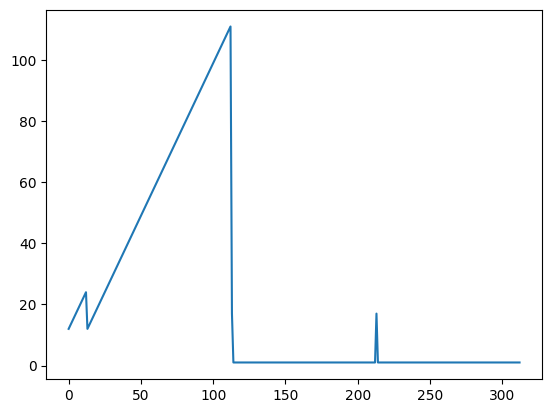

In [23]:
plt.plot(sizes)

In [24]:
model.config

FalconConfig {
  "_name_or_path": "tiiuae/falcon-rw-1b",
  "alibi": true,
  "apply_residual_connection_post_layernorm": false,
  "architectures": [
    "FalconForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "tiiuae/falcon-rw-1b--configuration_falcon.FalconConfig",
    "AutoModel": "tiiuae/falcon-rw-1b--modeling_falcon.FalconModel",
    "AutoModelForCausalLM": "tiiuae/falcon-rw-1b--modeling_falcon.FalconForCausalLM",
    "AutoModelForQuestionAnswering": "tiiuae/falcon-rw-1b--modeling_falcon.FalconForQuestionAnswering",
    "AutoModelForSequenceClassification": "tiiuae/falcon-rw-1b--modeling_falcon.FalconForSequenceClassification",
    "AutoModelForTokenClassification": "tiiuae/falcon-rw-1b--modeling_falcon.FalconForTokenClassification"
  },
  "bias": true,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_dropout": 0.0,
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "

In [25]:
model

FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(50304, 2048)
    (h): ModuleList(
      (0-2): 3 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (query_key_value): FalconLinear(in_features=2048, out_features=6144, bias=True)
          (dense): FalconLinear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): FalconLinear(in_features=2048, out_features=8192, bias=True)
          (act): GELU(approximate='none')
          (dense_4h_to_h): FalconLinear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      )
      (3): FalconDecoderLayer(
        (self_attention): Spy(
          (model): FalconAttention(
            (query_key_value):